In [25]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 1

# Specify each path

In [26]:
dataset = 'D:\VS_CODE_WORKSPACE\python\ML\hand-gesture-recognition-mediapipe-main\model\keypoint_classifier\keypoint.csv'
model_save_path = 'D:\VS_CODE_WORKSPACE\python\ML\hand-gesture-recognition-mediapipe-main\model\keypoint_classifier\keypoint_classifier.hdf5'
tflite_save_path = 'D:\VS_CODE_WORKSPACE\python\ML\hand-gesture-recognition-mediapipe-main\model\keypoint_classifier\keypoint_classifier.tflite'

# Set number of classes

In [27]:
NUM_CLASSES = 6

# Dataset reading

In [28]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [29]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [32]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [34]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [35]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/12 [=>............................] - ETA: 5s - loss: 1.9943 - accuracy: 0.1328
Epoch 1: saving model to D:\VS_CODE_WORKSPACE\python\ML\hand-gesture-recognition-mediapipe-main\model\keypoint_classifier\keypoint_classifier.hdf5
12/12 [==============================] - 1s 20ms/step - loss: 1.8773 - accuracy: 0.1596 - val_loss: 1.7099 - val_accuracy: 0.2770
Epoch 2/1000
 1/12 [=>............................] - ETA: 0s - loss: 1.8071 - accuracy: 0.2500
Epoch 2: saving model to D:\VS_CODE_WORKSPACE\python\ML\hand-gesture-recognition-mediapipe-main\model\keypoint_classifier\keypoint_classifier.hdf5
12/12 [==============================] - 0s 7ms/step - loss: 1.7511 - accuracy: 0.2432 - val_loss: 1.6400 - val_accuracy: 0.3951
Epoch 3/1000
 1/12 [=>............................] - ETA: 0s - loss: 1.7297 - accuracy: 0.2578
Epoch 3: saving model to D:\VS_CODE_WORKSPACE\python\ML\hand-gesture-recognition-mediapipe-main\model\keypoint_classifier\keypoint_classifier.hdf5
12/12 [=====

In [36]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

4/4 [==============================] - 0s 3ms/step - loss: 0.0570 - accuracy: 0.9817


In [37]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [38]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 48ms/step
[9.9506439e-04 1.5803881e-04 9.7992194e-01 7.7813644e-07 7.2949217e-07
 1.8923404e-02]
2


# Confusion matrix

16/16 [==============================] - 0s 1ms/step


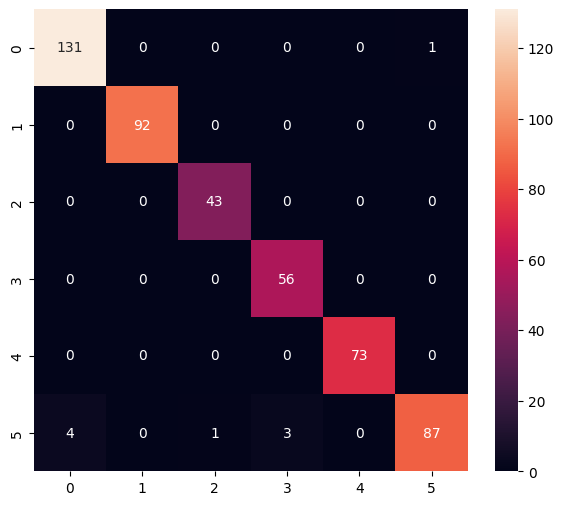

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       132
           1       1.00      1.00      1.00        92
           2       0.98      1.00      0.99        43
           3       0.95      1.00      0.97        56
           4       1.00      1.00      1.00        73
           5       0.99      0.92      0.95        95

    accuracy                           0.98       491
   macro avg       0.98      0.98      0.98       491
weighted avg       0.98      0.98      0.98       491



In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [40]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [41]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

6552

# Inference test

In [42]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [43]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [44]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [45]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [46]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.9506252e-04 1.5803854e-04 9.7992206e-01 7.7813428e-07 7.2948950e-07
 1.8923391e-02]
2
